In [ ]:
import os
import geopandas as gpd
import fiona

gdb_path = "data/Vanderbilt_Fire/FireData2022.gdb"
out_dir = "data/Vanderbilt_Fire"
os.makedirs(out_dir, exist_ok=True)

# List all layers in the geodatabase
layers = fiona.listlayers(gdb_path)

for layer in layers:
    gdf = gpd.read_file(gdb_path, layer=layer)
    out_geojson = os.path.join(out_dir, f"{layer}.geojson")
    try:
        gdf.to_file(out_geojson, driver="GeoJSON")
        print(f"  ✔  {layer} → {out_geojson}")
    except Exception as e:
        gdf.to_csv(out_geojson.replace('.geojson', '.csv'), index=False)


In [164]:
import pandas as pd        
import geopandas as gpd
incidents_path = 'data/Vanderbilt_Fire/FireIncidents.geojson'
apparatus_path = 'data/Vanderbilt_Fire/Apparatus.csv'
raw_incidents_df = gpd.read_file(incidents_path)
raw_apparatus_df = gpd.read_file(apparatus_path)

In [187]:
incidents_df= raw_incidents_df.copy()
apparatus_df = raw_apparatus_df.copy()



In [188]:

incidents_df['ResponseTime_Seconds'] = incidents_df['AlarmLastUnitClearTime'] - incidents_df['AlarmFirstUnitArriveTime']
incidents_df = incidents_df[( incidents_df['SuppressionPersonnelCount'].notna())&(incidents_df['EMSApparatusCount'].notna())& ((incidents_df['ResponseTime_Seconds'].notna())&(incidents_df['ResponseTime_Seconds']> 0)) &(incidents_df['AlarmFirstUnitArriveTime']>0) & (incidents_df['AlarmLastUnitClearTime']>0)]


#Write rules:
- Remove rows with NaN values in key columns
- Remove rows with negative or zero response times
- Remove outliers based on response time and alarm times

In [189]:
grouped_incidents = incidents_df.groupby('NFIRSType')
#Remove Nans, negatives, and empty strings, remove outliers per group
# Identify outliers 

# Filter out outliers

for name, group in grouped_incidents:
    q99 = group['ResponseTime_Seconds'].quantile(0.99)
    q98= group['AlarmFirstUnitArriveTime'].quantile(0.99)
    incidents_df = incidents_df[~((incidents_df['NFIRSType'] == name) & (incidents_df['ResponseTime_Seconds'] > q99))]
    incidents_df = incidents_df[~((incidents_df['NFIRSType'] == name) & (incidents_df['AlarmFirstUnitArriveTime'] > q98))]

In [190]:
len(incidents_df)/ len(raw_incidents_df) * 100

89.93808937942315

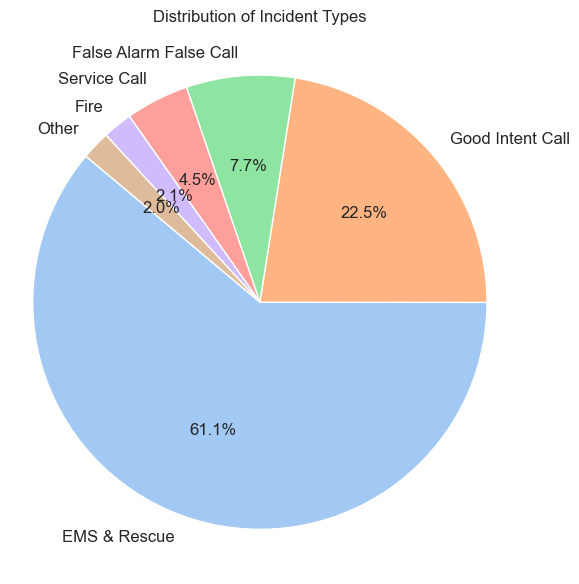

In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
os.makedirs("data/exploratory_analysis", exist_ok=True)
# 1. Compute counts and group tiny categories
counts = incidents_df['NFIRSType'].value_counts()
threshold = 0.02 * counts.sum()   # anything <5% of total
major = counts[counts >= threshold]
other = counts[counts < threshold].sum()
counts_clean = pd.concat([major, pd.Series({'Other': other})])

# 2. Plot
sns.set_theme(style="white")
colors = sns.color_palette("pastel", len(counts_clean))
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    counts_clean,
    labels=counts_clean.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor':'white', 'linewidth': 1},
    textprops={'fontsize': 12}
)
ax.set_title("Distribution of Incident Types")
ax.axis('equal')
plt.tight_layout()
plt.savefig("data/exploratory_analysis/incident_types_distribution.png", dpi=300)
plt.show()


Summary for ResponseTime_Seconds saved to data/exploratory_analysis/ResponseTime_Seconds_summary.csv


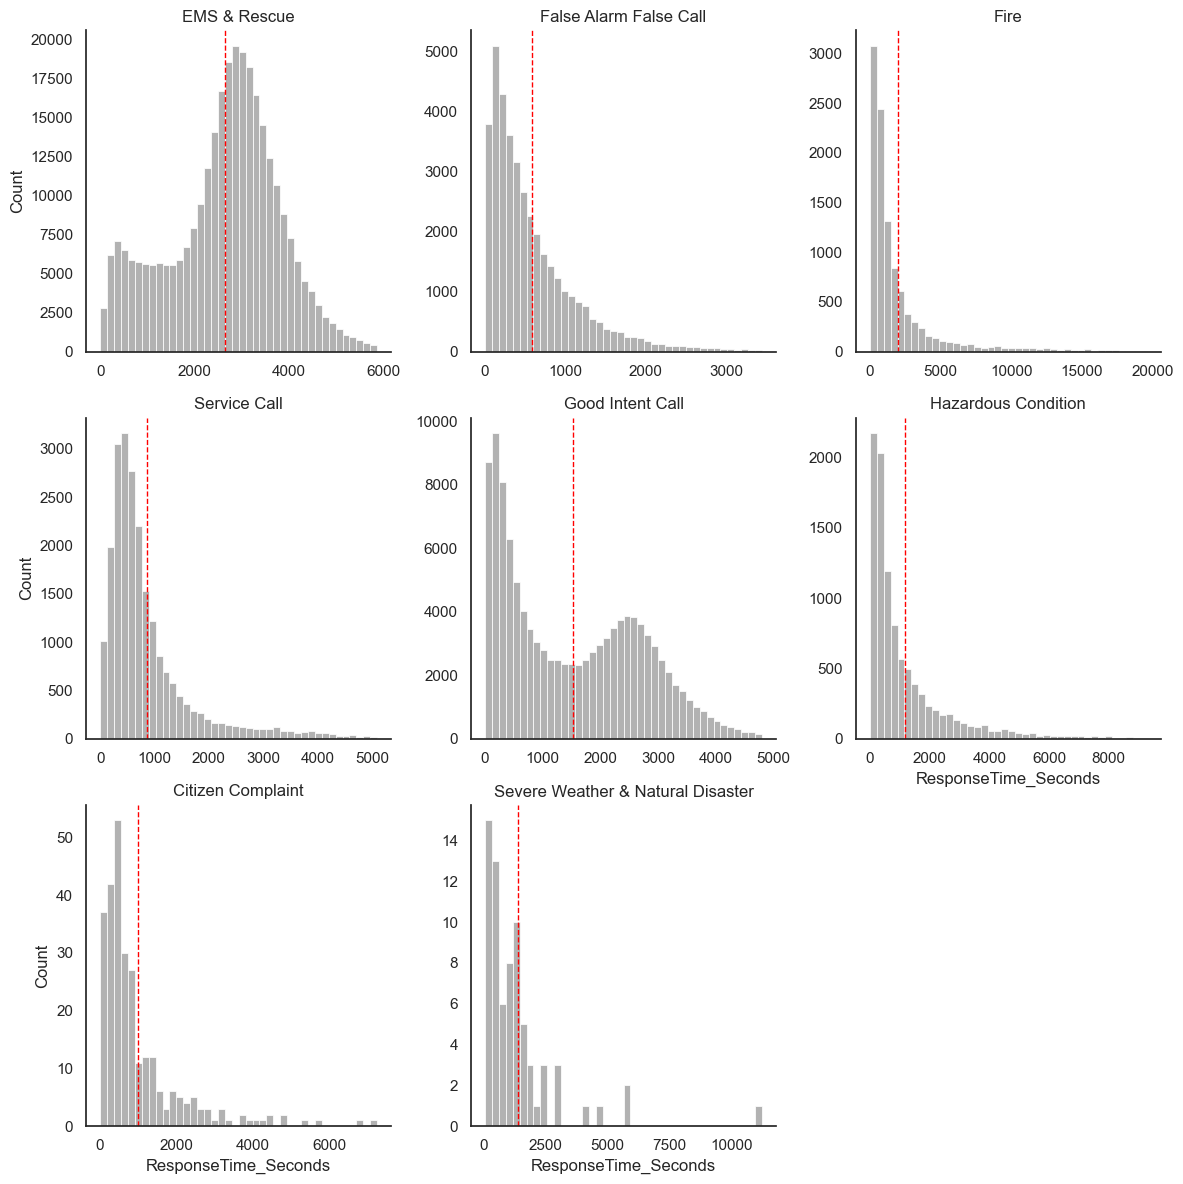

/var/folders/tf/7k8vj9w17715wv9yqsqn7pm00000gq/T/ipykernel_6064/3176857911.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NFIRSType", y=metric, data=incidents_df, palette="pastel")


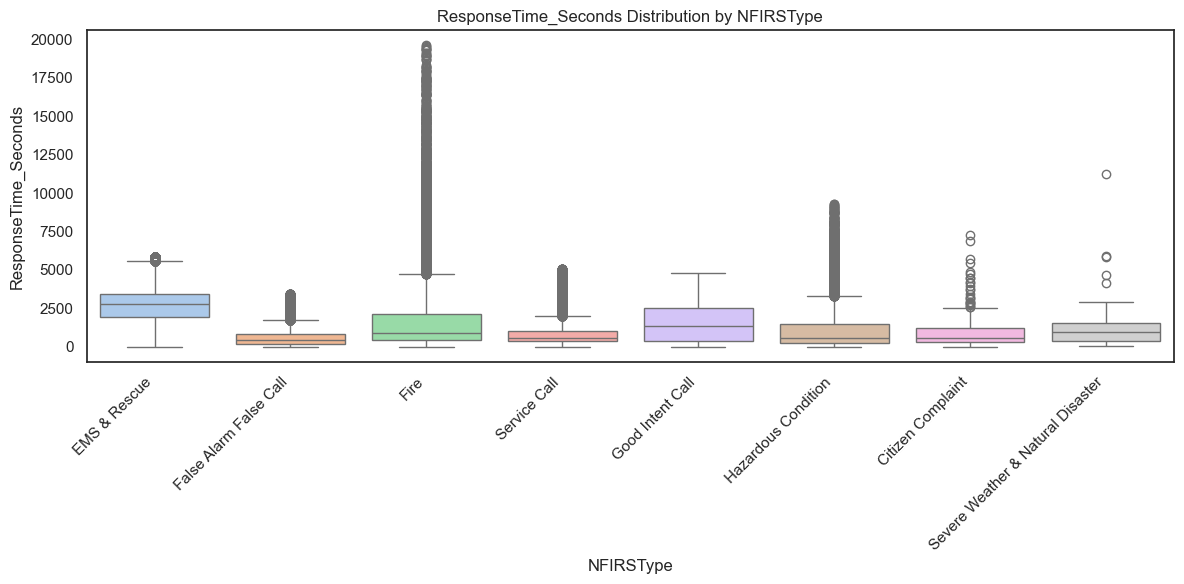

Summary for SuppressionApparatusCount saved to data/exploratory_analysis/SuppressionApparatusCount_summary.csv


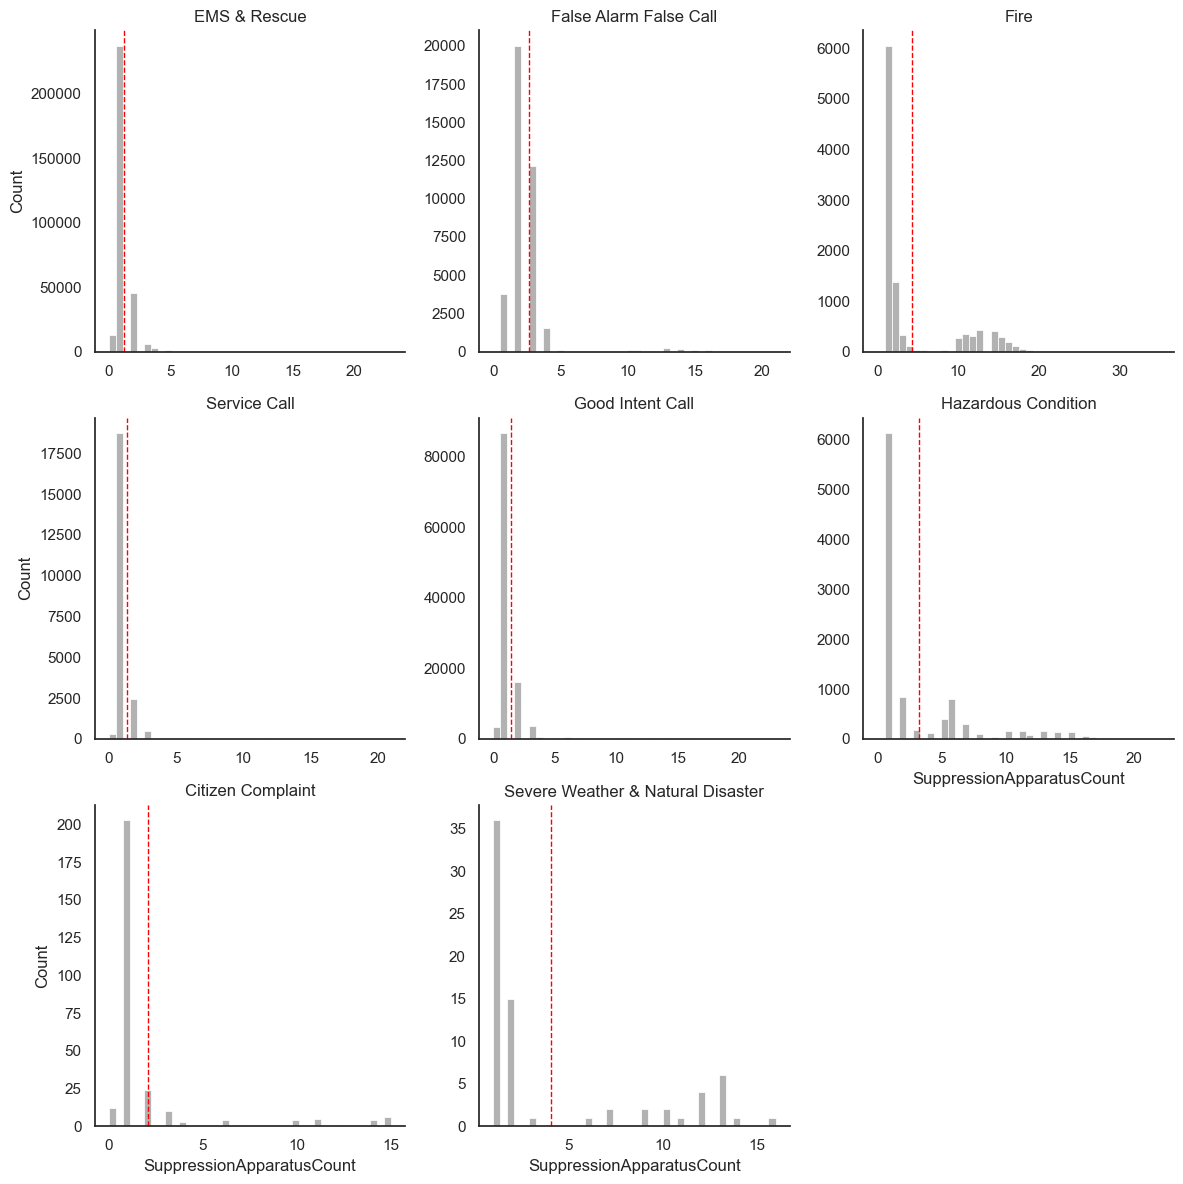

/var/folders/tf/7k8vj9w17715wv9yqsqn7pm00000gq/T/ipykernel_6064/3176857911.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NFIRSType", y=metric, data=incidents_df, palette="pastel")


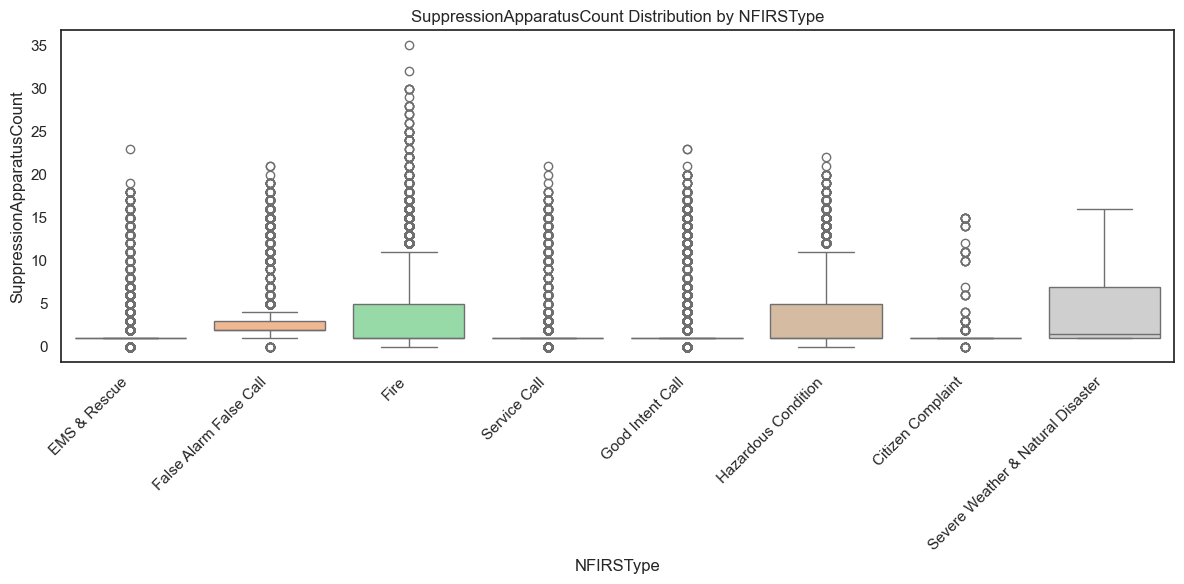

Summary for EMSApparatusCount saved to data/exploratory_analysis/EMSApparatusCount_summary.csv


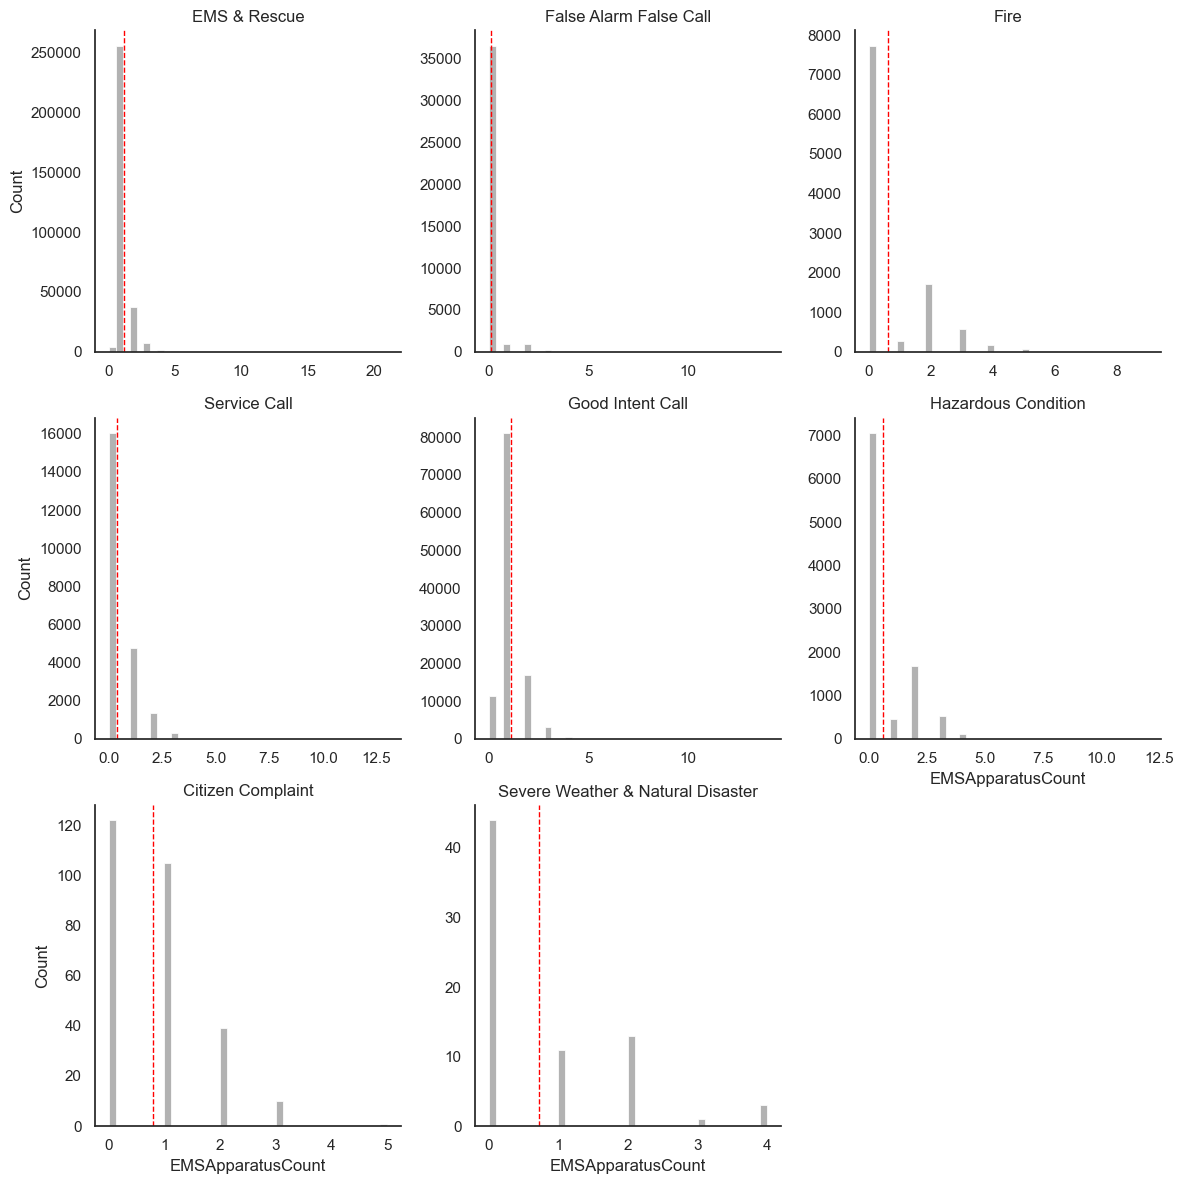

/var/folders/tf/7k8vj9w17715wv9yqsqn7pm00000gq/T/ipykernel_6064/3176857911.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NFIRSType", y=metric, data=incidents_df, palette="pastel")


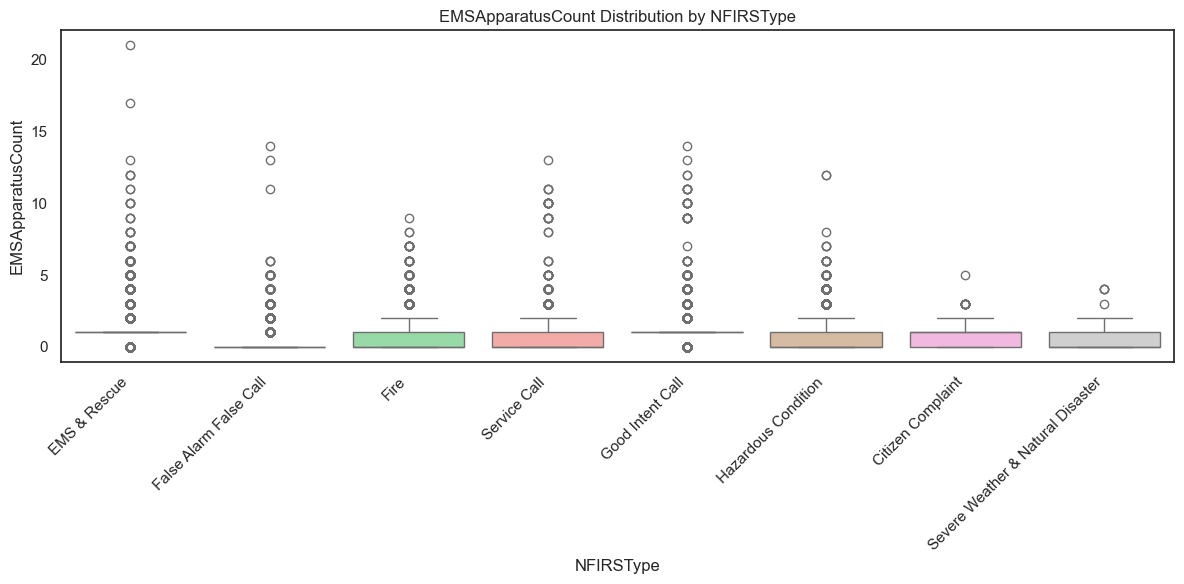

Summary for AlarmFirstUnitArriveTime saved to data/exploratory_analysis/AlarmFirstUnitArriveTime_summary.csv


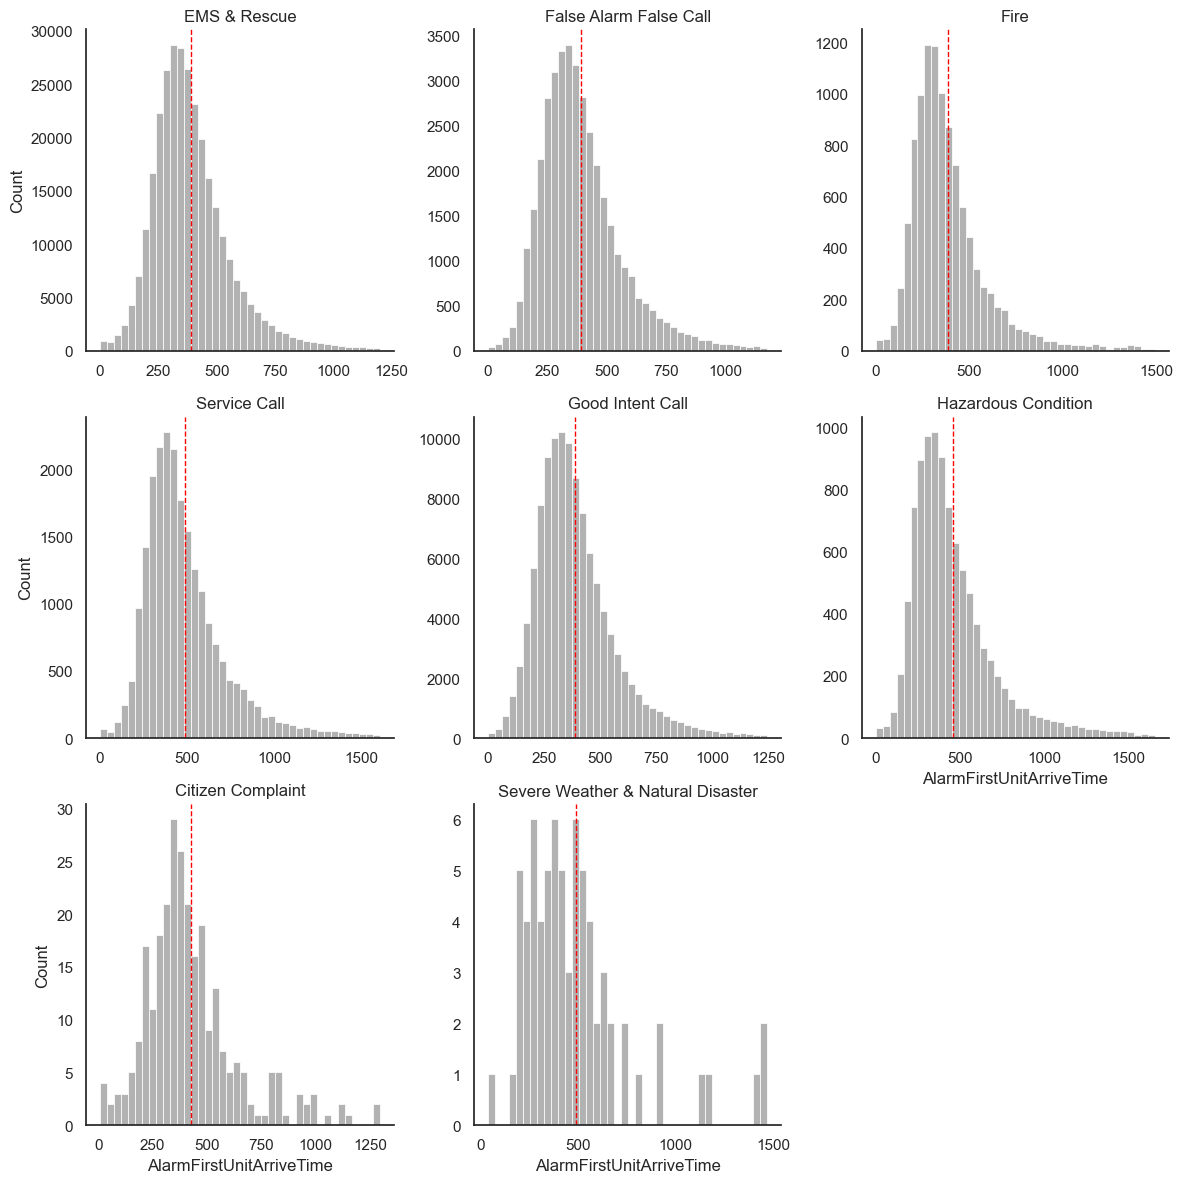

/var/folders/tf/7k8vj9w17715wv9yqsqn7pm00000gq/T/ipykernel_6064/3176857911.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NFIRSType", y=metric, data=incidents_df, palette="pastel")


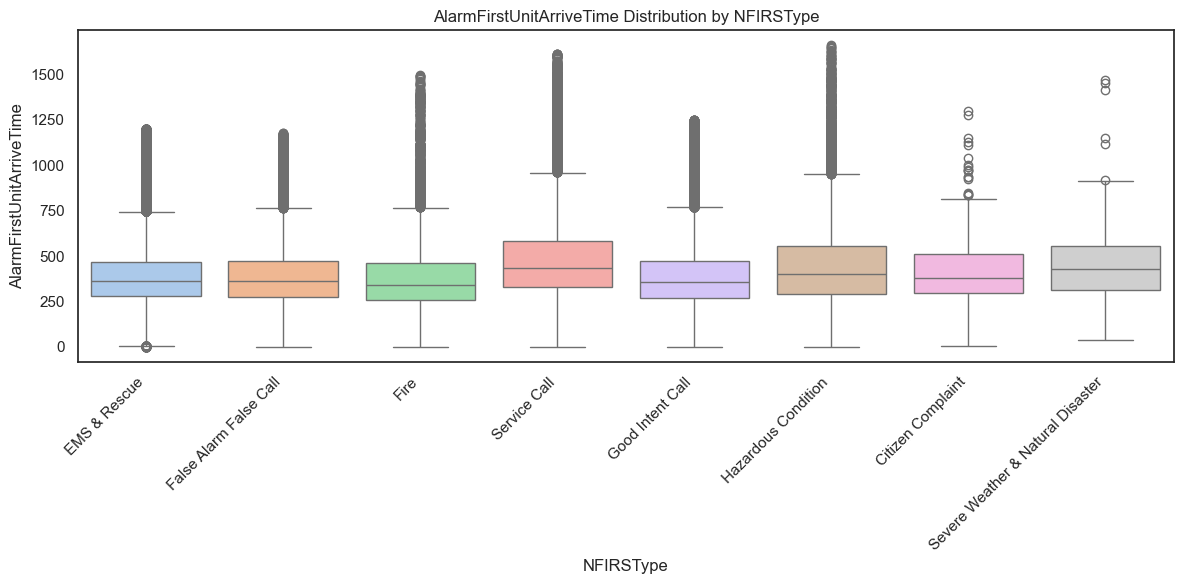

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
metrics = ["ResponseTime_Seconds", "SuppressionApparatusCount", "EMSApparatusCount",'AlarmFirstUnitArriveTime']
metrics_desc = []




for metric in metrics:
    os.makedirs(f"data/exploratory_analysis/{metric}", exist_ok=True)

# 1) Compute describe() on each group
for metric in metrics:
    incidents_df[metric] = incidents_df[metric].astype(float)  # Ensure numeric type
    summary = (
        incidents_df
          .groupby("NFIRSType")[metric]
          .describe()
    )
    summary.Name = metric
    summary = summary.reset_index()
    summary.to_csv(f"data/exploratory_analysis/{metric}/summary.csv", index=False)
    print(f"Summary for {metric} saved to data/exploratory_analysis/{metric}_summary.csv")

    
    metrics_desc.append((summary, metric))
    g = sns.FacetGrid(incidents_df, col="NFIRSType", col_wrap=3, height=4, sharex=False, sharey=False)
    g.map_dataframe(sns.histplot, x=metric, bins=40, kde=False, color=".6")
    g.map_dataframe(lambda data, color: plt.axvline(data[metric].mean(),
                                                    color="red", linestyle="--", linewidth=1),
                    )

    g.set_axis_labels(f"{metric}", "Count")
    g.set_titles("{col_name}")
    plt.tight_layout()
    plt.savefig(f"data/exploratory_analysis/{metric}/histogram.png")
    plt.show()
        
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="NFIRSType", y=metric, data=incidents_df, palette="pastel")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("NFIRSType")
    plt.ylabel(f"{metric}")
    plt.title(f"{metric} Distribution by NFIRSType")
    plt.tight_layout()
    plt.savefig(f"data/exploratory_analysis/{metric}/boxplot.png")
    plt.show()


# 2) Flatten the MultiIndex columns
#    e.g. ('ResponseTime_Seconds','mean') → 'ResponseTime_Seconds_mean'


#


In [110]:
apparatus_df.Apparatus_Resource_Vehicle_Category_Type.replace('None', None).isna().sum()

np.int64(789705)

In [111]:
list(apparatus_df.columns)

['Apparatus_ID_Internal',
 'Incident_ID_Internal',
 'Apparatus_Personnel_ID_List',
 'Apparatus_Personnel_Name_List',
 'Apparatus_Resource_Actions_Taken_1',
 'Apparatus_Resource_Actions_Taken_2',
 'Apparatus_Resource_Actions_Taken_3',
 'Apparatus_Resource_Actions_Taken_4',
 'Apparatus_Resource_Actions_Taken_Code_1',
 'Apparatus_Resource_Actions_Taken_Code_2',
 'Apparatus_Resource_Actions_Taken_Code_3',
 'Apparatus_Resource_Actions_Taken_Code_4',
 'Apparatus_Resource_Actions_Taken_Code_And_Description_1',
 'Apparatus_Resource_Actions_Taken_Code_And_Description_2',
 'Apparatus_Resource_Actions_Taken_Code_And_Description_3',
 'Apparatus_Resource_Actions_Taken_Code_And_Description_4',
 'Apparatus_Resource_Actions_Taken_Code_And_Description_List',
 'Apparatus_Resource_Actions_Taken_Code_List',
 'Apparatus_Resource_Actions_Taken_List',
 'Apparatus_Resource_Arrival_Date_Time',
 'Apparatus_Resource_Arrived_To_Cleared_In_HHMMSS',
 'Apparatus_Resource_Arrived_To_Cleared_In_Minutes',
 'Apparatus_R

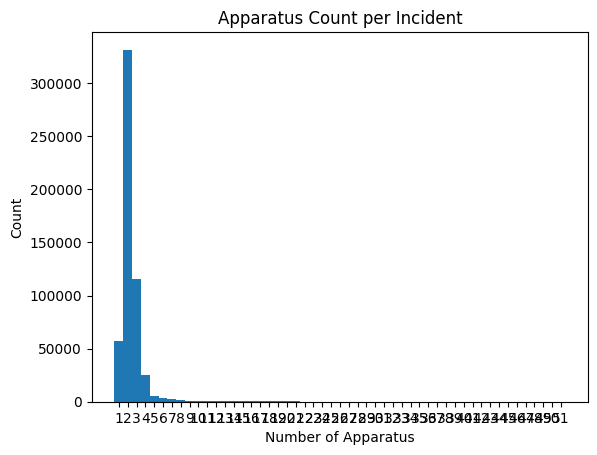

In [8]:
apparatus_counts = df_app.groupby('Incident_ID_Internal')['Apparatus_ID_Internal'].nunique()

plt.figure()
plt.hist(apparatus_counts, bins=range(1, apparatus_counts.max()+2), align='left')
plt.title('Apparatus Count per Incident')
plt.xlabel('Number of Apparatus')
plt.ylabel('Count')
plt.xticks(range(1, apparatus_counts.max()+1))
plt.show()

In [96]:
apparatus_df[['Apparatus_Resource_Arrival_Sequence_Number_By_Overall_Incident',
 'Apparatus_Resource_Arrival_Sequence_Number_By_Apparatus_Type',
 'Apparatus_Resource_Narrative']].replace('', None).isna().sum()

Apparatus_Resource_Arrival_Sequence_Number_By_Overall_Incident    425275
Apparatus_Resource_Arrival_Sequence_Number_By_Apparatus_Type      425564
Apparatus_Resource_Narrative                                      560953
dtype: int64

In [95]:
apparatus_df

,Apparatus_ID_Internal,Incident_ID_Internal,Apparatus_Personnel_ID_List,Apparatus_Personnel_Name_List,Apparatus_Resource_Actions_Taken_1,Apparatus_Resource_Actions_Taken_2,Apparatus_Resource_Actions_Taken_3,Apparatus_Resource_Actions_Taken_4,Apparatus_Resource_Actions_Taken_Code_1,Apparatus_Resource_Actions_Taken_Code_2,...,Apparatus_Resource_Last_Arrived_At_Scene_Date_Time,Apparatus_Resource_Primary_Action_Taken,Apparatus_Resource_Primary_Action_Taken_Code,Apparatus_Resource_Primary_Action_Taken_Code_And_Description,Apparatus_Resource_Arrival_Sequence_Number_By_Overall_Incident,Apparatus_Resource_Arrival_Sequence_Number_By_Apparatus_Type,Apparatus_Resource_Narrative,Apparatus_Resource_Dispatch_Location,Apparatus_Resource_First_Unit_Arrived_To_Last_Unit_Arrived_in_Se,Apparatus_Resource_First_Unit_Arrived_To_Last_Unit_Arrived_in_Mi
0,3224082,1390914,,,,,,,,,...,,,,,1.0,1.0,,,,
1,3224086,1390917,,,,,,,,,...,,,,,1.0,1.0,,,,
2,3224087,1390917,"716801, 239398, 434994, 824096","Henry (Dillon) Brackman, David Christian, Cody...",,,,,,,...,,Cancelled en route,93,93 - Cancelled en route,,,RE12C was cancelled en route by MED15 and retu...,,,
3,3224088,1390918,,,,,,,,,...,,,,,2.0,2.0,,,,
4,3224091,1390920,"224513, 4001356, 461776","Julie Haynes, Andrea Mason, Constance Swett",,,,,,,...,,Provide basic life support (BLS),32,32 - Provide basic life support (BLS),1.0,1.0,EN25C see medic report. EN25C back in service.,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381986,7577209,3190793,"416193, 309272, 4006534","Lawrence Jr Williams, Jacob Welbaum, Austin (C...",,,,,,,...,,Provide basic life support (BLS),32,32 - Provide basic life support (BLS),1.0,1.0,See med report,,,
1381987,7577210,3190794,"438458, 269278, 4007124","David Monast, Steven (Michael) Ward, Devan Pierce",,,,,,,...,,,,,1.0,1.0,,,,
1381988,7577211,3190794,,,,,,,,,...,,,,,2.0,1.0,,,,
1381989,7577212,3190795,"161923, 4010901, 4011604","John Davis, Levi Jr. Johnson, Clayton Yates",,,,,,,...,,Provide manpower,73,73 - Provide manpower,1.0,1.0,see medical report,,,


In [12]:
incidents_df.NFIRSType.unique()  # Check unique incident types in incidents data


array(['EMS & Rescue', 'False Alarm False Call', 'Fire',
       'Good Intent Call', 'Service Call', 'Hazardous Condition',
       'Citizen Complaint', 'Severe Weather & Natural Disaster'],
      dtype=object)

In [ ]:
apparatus_df # Check unique property pre-incident values in incidents data

array([None, 'Non-Fire Incidents', 'Non-Structure Fire',
       'Residential Structure Fire', 'Non-Residential Structure Fire'],
      dtype=object)